# Evaluate Model Displacement Data

## Data Layout

Data is provided in tabular CSV format.
Columns:

* "Country" specifies the country identifier in ISO 3166-1 alpha-3 code.
* "Protection" specifies the type of model: We run two independent calibration setups based on two flood models.
  The "No Protection" flood model assumes no protection against floods.
  The "FLOPROS" model assumes flood protection standards according to the FLOPROS database.
  The results from these models are distinct and should not be combined (e.g., by computing the mean over impacts from both models).
* "Impact Func ID" gives the index of the impact function received through calibration.
  These indices are not persisent over the models; ID 0 for "No Protection" is not related to ID 0 from "FLOPROS".
  Calculating statistics by iterating over "Impact Func ID" (for one protection model) quantifies the calibration uncertainty.

## Per-Year Data

In [48]:
import pandas as pd

per_year_df = pd.read_csv("displacement_per_year.csv")
per_year_df

,Impact,Year,Country,Protection,Impact Func ID
0,2.461736e+04,2008,ETH,No Protection,0
1,1.500924e+04,2009,ETH,No Protection,0
2,1.023012e+05,2010,ETH,No Protection,0
3,3.581929e+04,2011,ETH,No Protection,0
4,5.139161e+04,2012,ETH,No Protection,0
...,...,...,...,...,...
1795,1.259746e+05,2018,SDN,FLOPROS,19
1796,1.498904e+06,2019,SDN,FLOPROS,19
1797,1.683337e+06,2020,SDN,FLOPROS,19
1798,2.595851e+05,2021,SDN,FLOPROS,19


Load IDMC data

In [49]:
import numpy as np

idmc_df = pd.read_excel("data/IDMC_GIDD_Disasters_Internal_Displacement_Data.xlsx")
idmc_df = (
    idmc_df.set_index("Date of Event (start)")
    .groupby("ISO3")["Disaster Internal Displacements"]
    .resample("1y")
    .sum()
    .replace(0, np.nan)
    .reset_index()
)
idmc_df["Year"] = idmc_df["Date of Event (start)"].dt.year
idmc_df = idmc_df.drop(columns="Date of Event (start)").rename(
    columns={"ISO3": "Country"}
)
idmc_df

,Country,Disaster Internal Displacements,Year
0,ETH,72810.0,2008
1,ETH,NaN,2009
2,ETH,10000.0,2010
3,ETH,NaN,2011
4,ETH,20000.0,2012
5,ETH,60300.0,2013
6,ETH,46880.0,2014
7,ETH,90540.0,2015
8,ETH,347000.0,2016
9,ETH,52170.0,2017


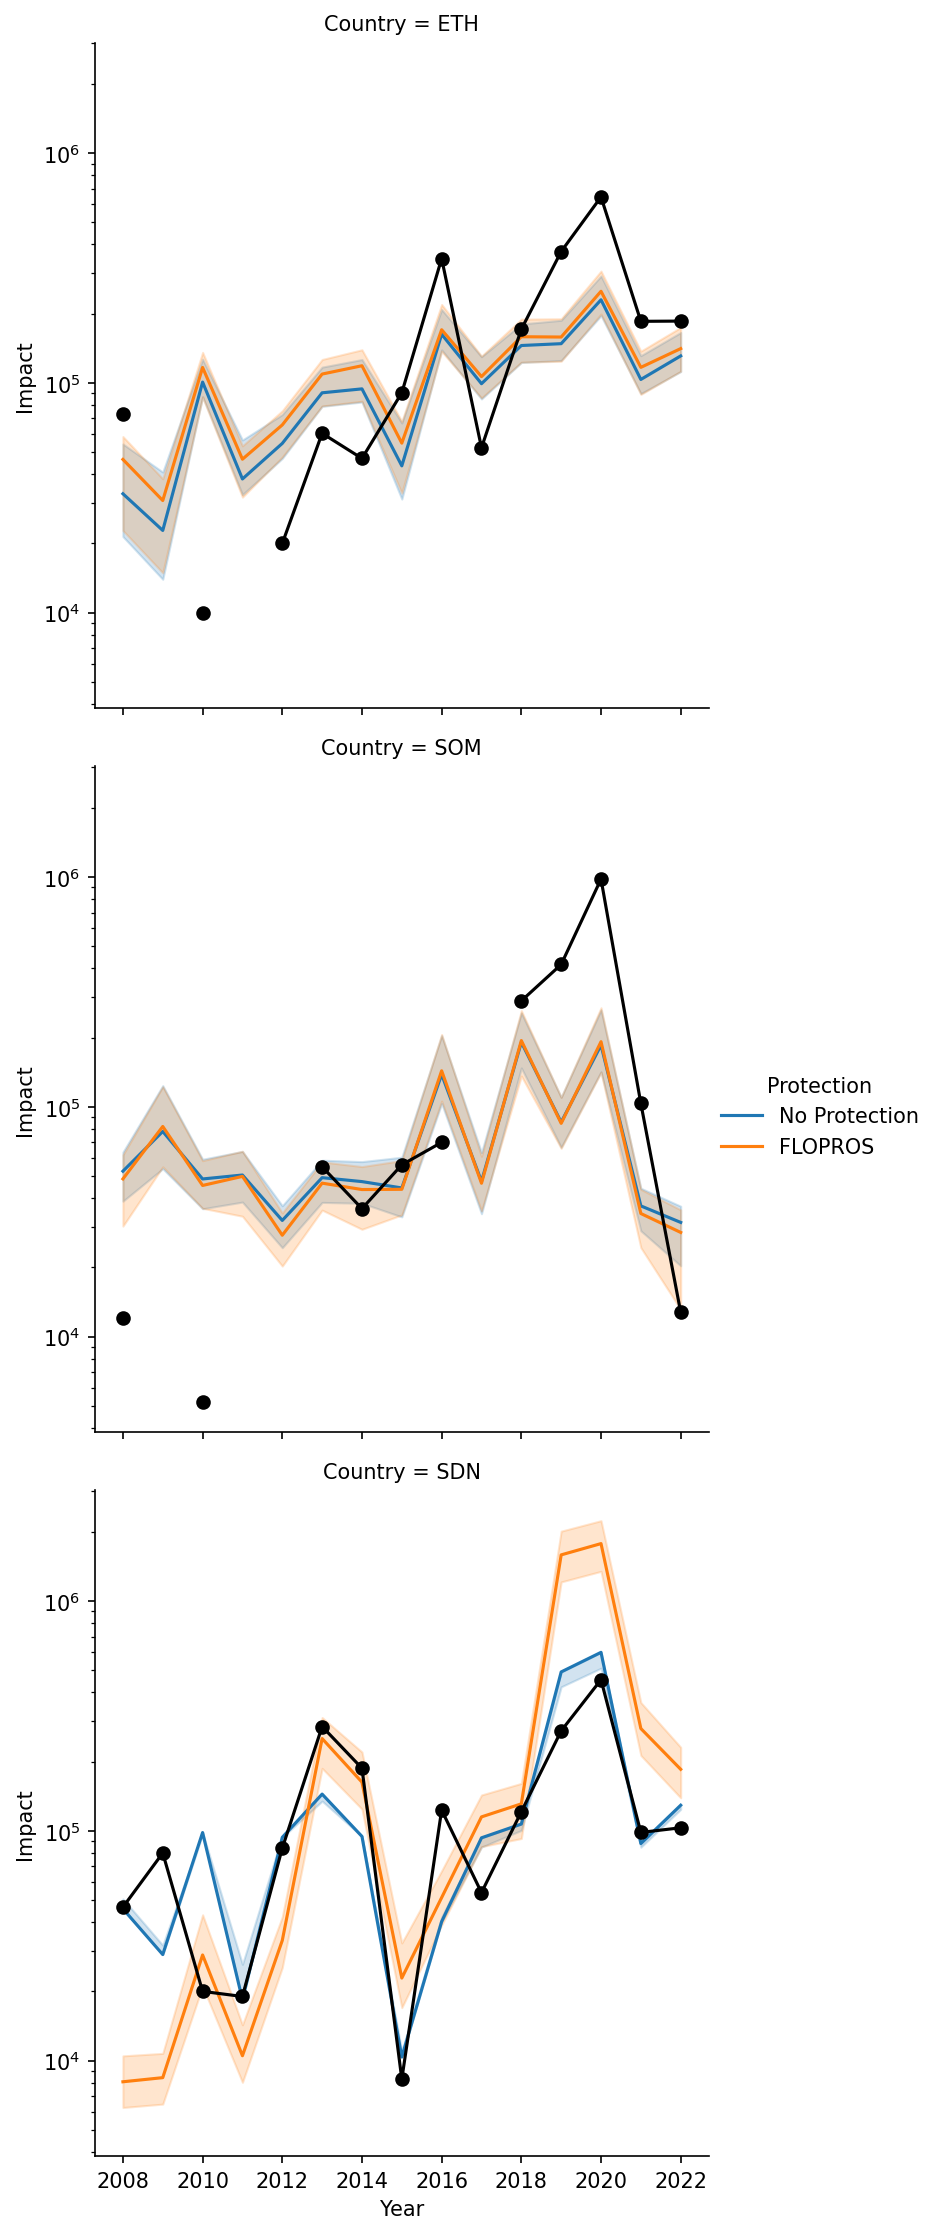

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 150

countries = ["ETH", "SOM", "SDN"]
facet = sns.relplot(
    data=per_year_df,
    x="Year",
    y="Impact",
    hue="Protection",
    row="Country",
    kind="line",
    estimator="median",
    errorbar="pi",
)

# Show IDMC data we calibrated on
for ctry, ax in zip(countries, facet.axes.flat):
    idmc_data = idmc_df.loc[idmc_df["Country"] == ctry]
    ax.plot(
        idmc_data["Year"], idmc_data["Disaster Internal Displacements"], "o-", color="k"
    )
facet.axes[0, 0].set_yscale("log")

## Sum of Modeled Displacement

Sum per country

In [51]:
sum_df = per_year_df.groupby(
    ["Country", "Protection", "Impact Func ID"]
)["Impact"].sum().rename("Total Displacement 2008 - 2022").reset_index()
sum_df

,Country,Protection,Impact Func ID,Total Displacement 2008 - 2022
0,ETH,FLOPROS,0,1.491170e+06
1,ETH,FLOPROS,1,1.622013e+06
2,ETH,FLOPROS,2,2.023403e+06
3,ETH,FLOPROS,3,1.571427e+06
4,ETH,FLOPROS,4,1.412835e+06
...,...,...,...,...
115,SOM,No Protection,15,1.235233e+06
116,SOM,No Protection,16,1.042461e+06
117,SOM,No Protection,17,1.395815e+06
118,SOM,No Protection,18,1.134808e+06


<Axes: xlabel='Country', ylabel='Total Displacement 2008 - 2022'>

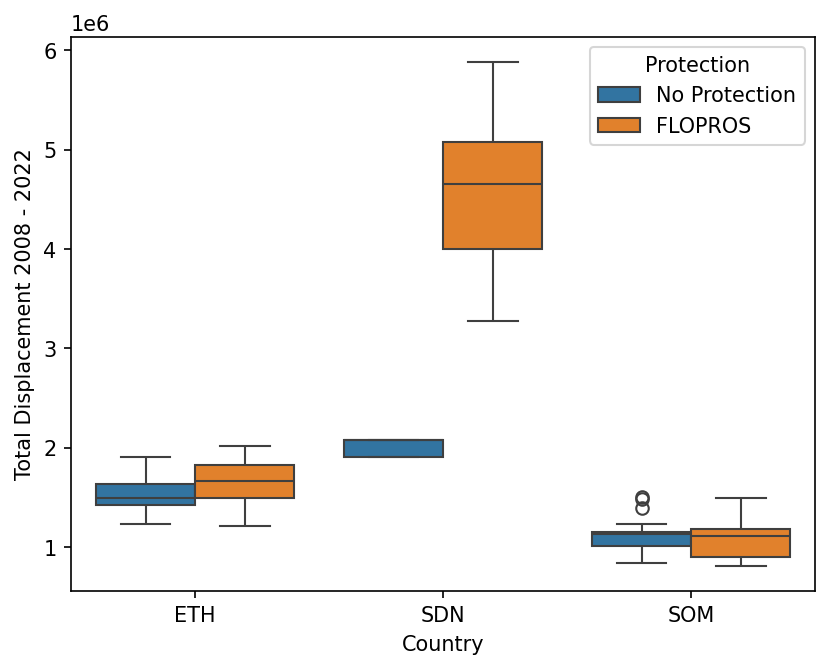

In [52]:
sns.boxplot(
    data=sum_df,
    x="Country",
    y="Total Displacement 2008 - 2022",
    hue="Protection",
    hue_order=["No Protection", "FLOPROS"],
)


Sum for all countries

In [53]:
sum_all_df = (
    sum_df.groupby(["Protection", "Impact Func ID"])["Total Displacement 2008 - 2022"]
    .sum()
    .reset_index()
)
sum_all_df

,Protection,Impact Func ID,Total Displacement 2008 - 2022
0,FLOPROS,0,6.488149e+06
1,FLOPROS,1,7.439411e+06
2,FLOPROS,2,8.904106e+06
3,FLOPROS,3,5.725074e+06
4,FLOPROS,4,8.620403e+06
5,FLOPROS,5,7.775822e+06
6,FLOPROS,6,8.248849e+06
7,FLOPROS,7,8.288416e+06
8,FLOPROS,8,7.194218e+06
9,FLOPROS,9,7.609085e+06


<Axes: ylabel='Total Displacement 2008 - 2022'>

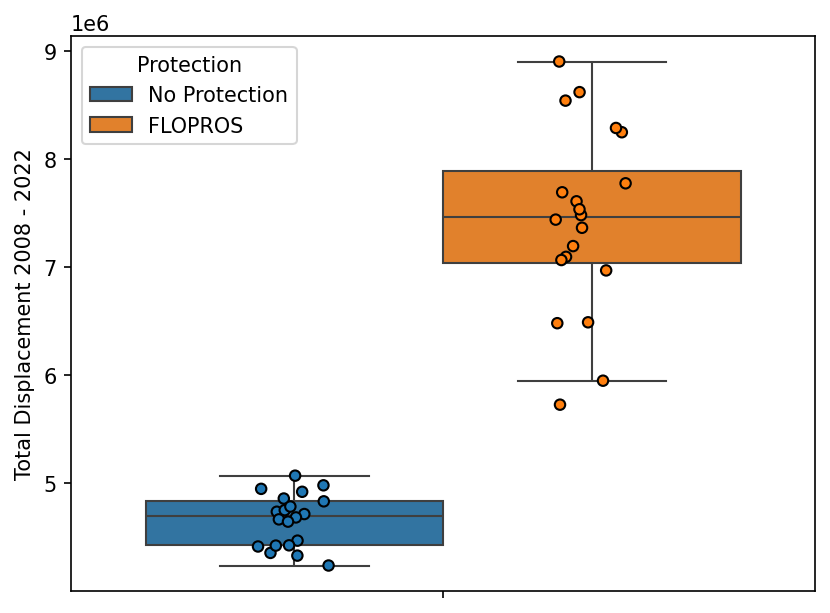

In [54]:
sns.boxplot(
    data=sum_all_df,
    # x="Country",
    y="Total Displacement 2008 - 2022",
    hue="Protection",
    hue_order=["No Protection", "FLOPROS"],
    showfliers=False,
)
sns.stripplot(
    data=sum_all_df,
    y="Total Displacement 2008 - 2022",
    hue="Protection",
    hue_order=["No Protection", "FLOPROS"],
    # color="k",
    edgecolor="k",
    linewidth=1.0,
    dodge=True,
    legend=False,
)

## Historical Average Annual Displacement

This is basically the sum divided by the number of years.

In [55]:
haad_df = (
    per_year_df.groupby(["Country", "Protection", "Impact Func ID"])["Impact"]
    .mean()
    .rename("HAAD")
    .reset_index()
)
haad_df

,Country,Protection,Impact Func ID,HAAD
0,ETH,FLOPROS,0,99411.302968
1,ETH,FLOPROS,1,108134.224692
2,ETH,FLOPROS,2,134893.500566
3,ETH,FLOPROS,3,104761.778555
4,ETH,FLOPROS,4,94188.995499
...,...,...,...,...
115,SOM,No Protection,15,82348.882591
116,SOM,No Protection,16,69497.408869
117,SOM,No Protection,17,93054.334685
118,SOM,No Protection,18,75653.895105


<Axes: xlabel='Country', ylabel='HAAD'>

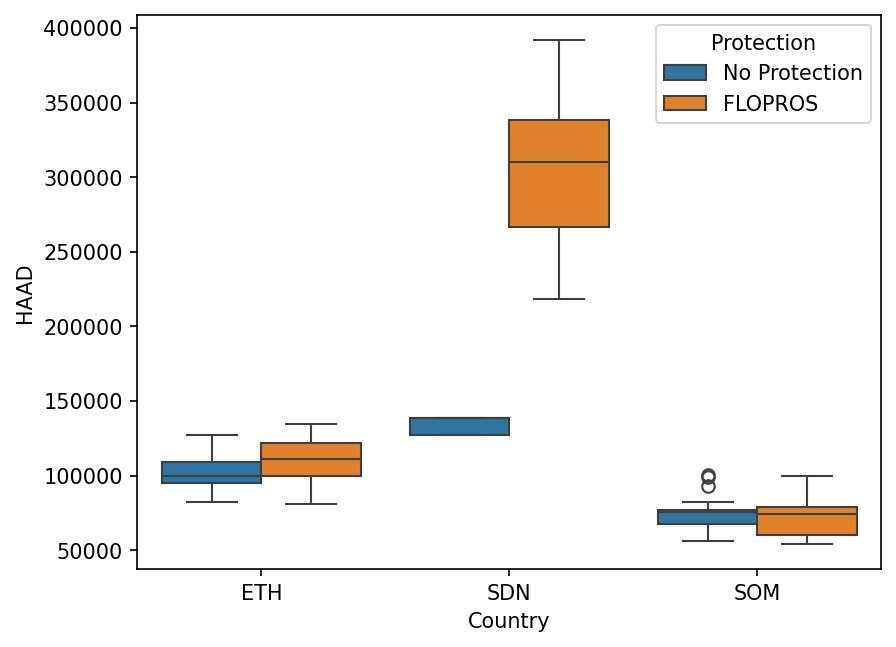

In [56]:
sns.boxplot(
    data=haad_df,
    x="Country",
    y="HAAD",
    hue="Protection",
    hue_order=["No Protection", "FLOPROS"],
)

## Average Annual Displacement (AAD)

In [57]:
aad_df = pd.read_csv("aad.csv")
aad_df

,Country,Protection,Impact Func ID,AAD
0,ETH,FLOPROS,0,99747.834129
1,ETH,FLOPROS,1,108756.405075
2,ETH,FLOPROS,2,135046.162447
3,ETH,FLOPROS,3,104963.500588
4,ETH,FLOPROS,4,94330.495034
...,...,...,...,...
115,SOM,No Protection,15,77874.423296
116,SOM,No Protection,16,65959.595982
117,SOM,No Protection,17,87793.557055
118,SOM,No Protection,18,71680.977190


<Axes: xlabel='Country', ylabel='AAD'>

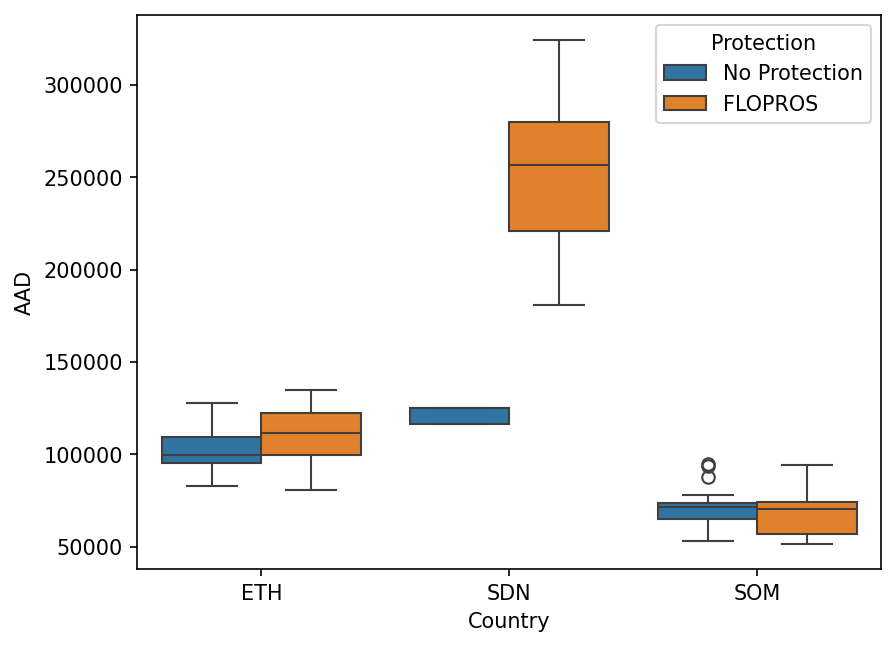

In [58]:
sns.boxplot(
    data=aad_df,
    x="Country",
    y="AAD",
    hue="Protection",
    hue_order=["No Protection", "FLOPROS"],
)

## Probable Maximum Displacement

In [59]:
pmd_df = pd.read_csv("pmd.csv")
pmd_df

,Country,Protection,Impact Func ID,Return Period,PMD
0,ETH,FLOPROS,0,2,89360.095983
1,ETH,FLOPROS,0,5,145237.104682
2,ETH,FLOPROS,0,10,182232.208310
3,ETH,FLOPROS,0,25,228976.099926
4,ETH,FLOPROS,0,50,263653.018152
...,...,...,...,...,...
715,SOM,No Protection,19,5,102800.368729
716,SOM,No Protection,19,10,126851.012260
717,SOM,No Protection,19,25,157239.376238
718,SOM,No Protection,19,50,179782.959502


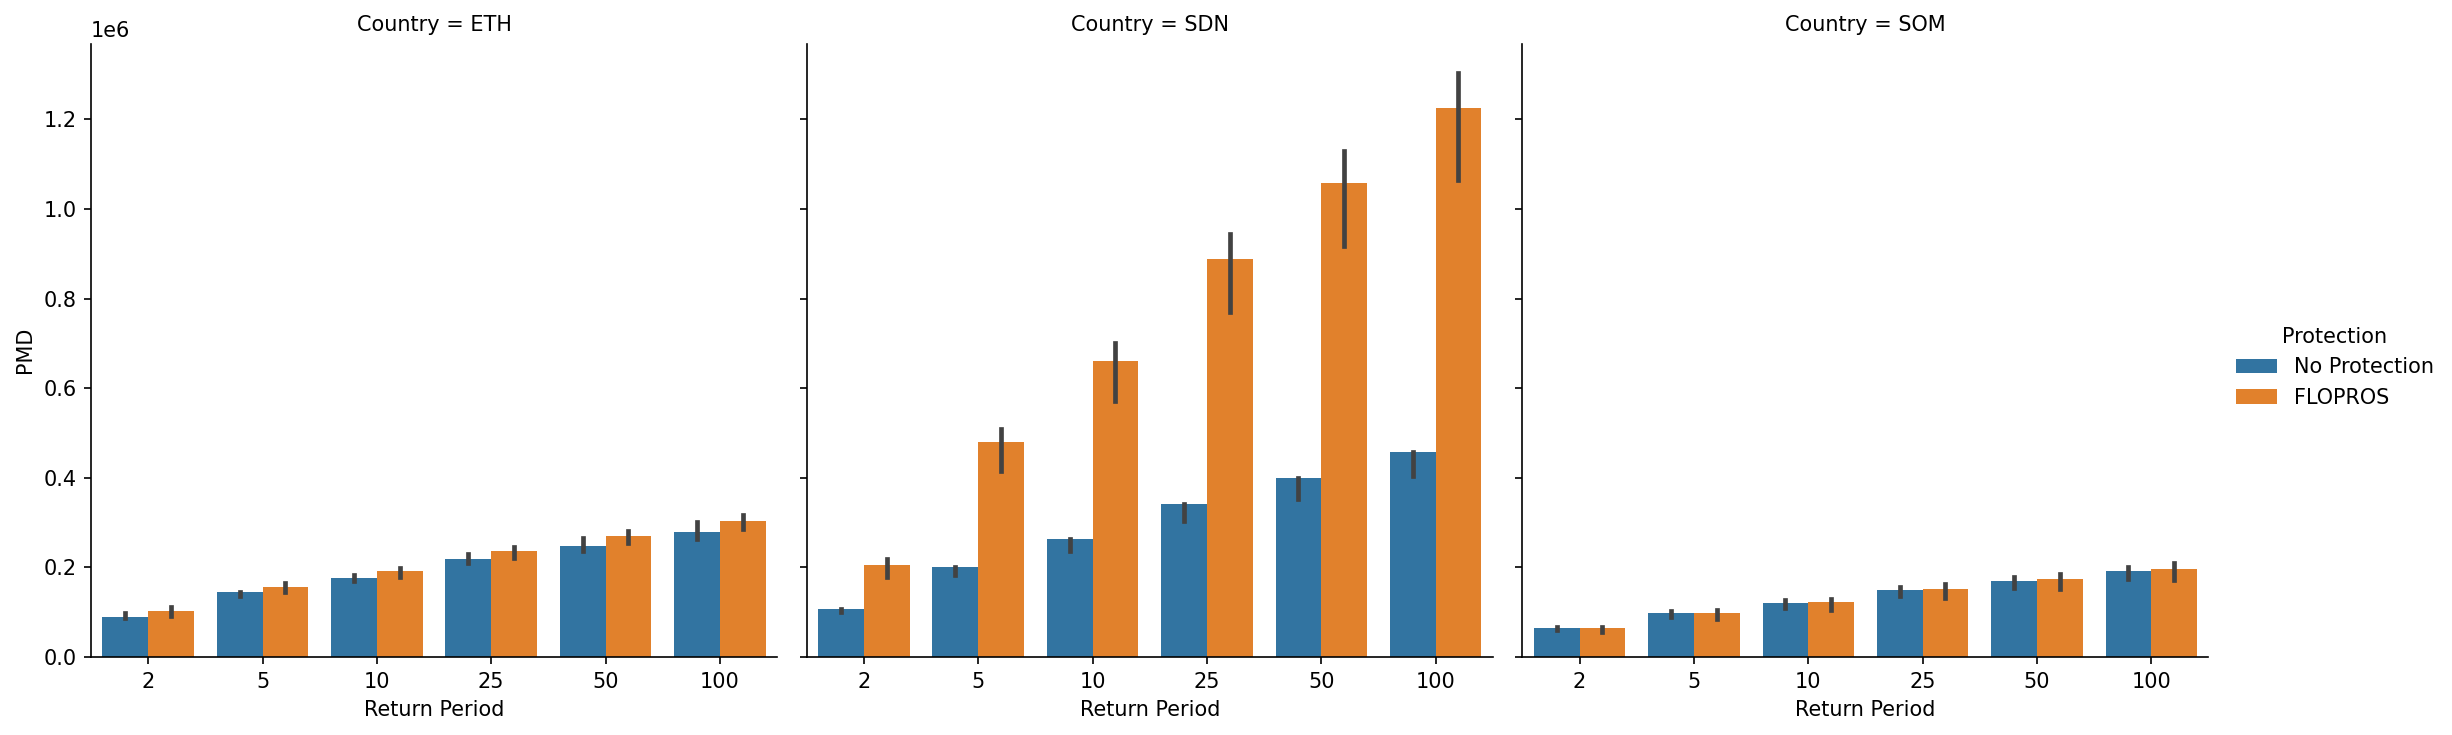

In [60]:
sns.catplot(
    data=pmd_df,
    x="Return Period",
    y="PMD",
    hue="Protection",
    col="Country",
    estimator="median",
    errorbar="ci",
    hue_order=["No Protection", "FLOPROS"],
    kind="bar",
)